# ORIE 4580/5580/5581 Assignment 4

#### Students: Chenxin Fang (cf348) and Aaron Ye (ajy33)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)


### Instructions


* Due Friday September 29, at 11.59am on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/56826#:~:text=Assignments-,Assignments,-Assignments%20Module%20publish). Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Bard or ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**. You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [1]:
# Preamble to make sure we have all packages we need
import numpy as np

# Configuring matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'Set3'

# Choosing a colormap for the plot colors
cmap=plt.get_cmap('Set3')




---
---


# Question 1: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


___
## Ans.


In [2]:
import numpy as np
from scipy.stats import norm
miu = np.array([0.14, 0.07, 0.16])
sigma = np.array([0.0625, 0.01, 0.09])
std = np.sqrt(sigma)
z = -1 * miu / std
prob = norm.cdf(z)
p_pos = 1
for p in prob:
  p_pos *= 1-p
print("all three financial products simultaneously yield a positive return = {}".format(p_pos))

all three financial products simultaneously yield a positive return = 0.3796164056673423


___

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
___

## Ans.



In [27]:
import scipy
from scipy.linalg import sqrtm
cov = [[0.0625 , -0.01, 0.0375],
       [-0.01, 0.01, -0.015],
       [0.0375, -0.015, 0.09]]

N = 10000
L_1 = scipy.linalg.cholesky(cov, lower=True)
res = np.zeros(N)
for i in range(N):
  X = np.random.normal(size=3)
  Y_1 = miu + np.dot(L_1,X)
  if sum(Y_1 > 0.0) == 3:
    res[i] = True

p_sim = sum(res)/N
print("all three financial products simultaneously yield a positive return = {}".format(p_sim))

all three financial products simultaneously yield a positive return = 0.3763


In [17]:
L_1

array([[ 0.25      ,  0.        ,  0.        ],
       [-0.04      ,  0.09165151,  0.        ],
       [ 0.15      , -0.09819805,  0.24053512]])

___
___

# Question 2: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

___

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.
___


## Ans.


variance of uniform distribution is $(𝑏−𝑎)^2/12$ \
mean is $(b+a)/2$ \
(b+a)/2 = 0 \
a = -b \
$(𝑏−𝑎)^2/12 = 4b^2/12 = 1$\
$b=\sqrt{3}, a = -\sqrt3$


___

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?
___

## Ans.


$\mathbb{E}[V_2] = 0 $ and $Var(V_2) = 1$

\begin{align*}
\mathbb{E}[V_2] = \mathbb{E}[(1-B)X_1] + \mathbb{E}[BX_2] \\
= \mathbb{E}[\mathbb{E}[X_1|1-B](1−𝐵)] + \mathbb{E}[\mathbb{E}[X_2|B]B] \\
\text{since $X_i$ and P are independent of each other} \\
\text{$\mathbb{E}[X_1|1-B]=\mathbb{E}[X_1]$, similarly for $X_2$} \\
\mathbb{E}[V_2] = \mathbb{E}[0*(1-B)] + \mathbb{E}[0*B] = 0 \\
Var(V_2) = \mathbb{E}[V_2^2] - \mathbb{E}[V_2]^2 = \mathbb{E}[V_2^2] \\
= \mathbb{E}[\mathbb{E}[X_1|1-B]^2(1-B)^2] + \mathbb{E}[\mathbb{E}[X_2|B]^2B^2] \\
= \mathbb{E}[(1-B)^2] + \mathbb{E}[B^2] = 1-2\mathbb{E}[B] + 2\mathbb{E}[B^2]\\
\mathbb{E}[B^2] = Var(B) + \mathbb{E}[B]^2 = p(1-p) + p^2 = p \\
\text{plug in to equation above} \\
Var(V_2) = 1 -2p + 2p = 1
\end{align*}

___
**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?
___

## Ans.


\begin{align*}
Cov(V_1, V_2) = \mathbb{E}[(V_1-\mathbb{E}[V_1])(V_2-\mathbb{E}[V_2])] = \mathbb{E}[V_1V_2] = \mathbb{E}[(1-B)X_1^2 + BX_1X_2]\\
= \mathbb{E}[(1-B)\mathbb{E}[X_1^2|B]] + \mathbb{E}[B\mathbb{E}[X_1X_2|B]] = \mathbb{E}[1-B] + 0 = 1 - p = \sigma_{12} \\
p = 1 - \sigma_{12}
\end{align*}

___

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

___

## Ans.

In [ ]:
corr = [0, 0.25, 0.5, 0.75, 1]
a = -np.sqrt(3)
b = np.sqrt(3)

def get_v(cor):
  X = np.random.uniform(a, b, 2)
  B = np.random.rand() >= cor
  V = np.array([X[0], X[1] if B else X[0]])
  return V

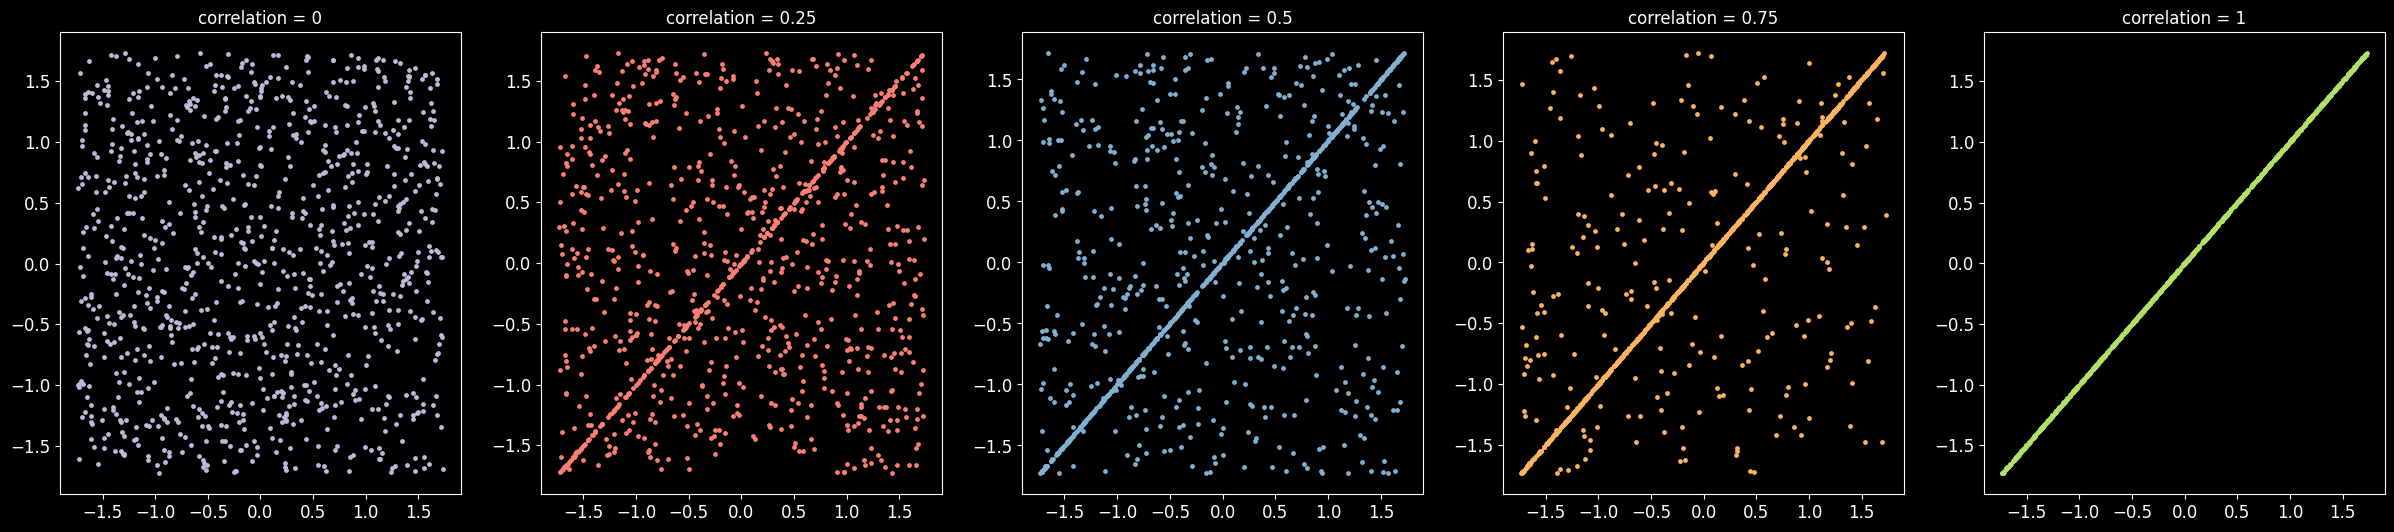

In [ ]:
N = 1000
fig, axes = plt.subplots(1, 5, figsize=(30,6))
for i, c in enumerate(corr):
  V = np.zeros((N,2))
  for j in range(N):
    V[j,:] = get_v(c)

  axes[i].scatter(V[:,0],V[:,1],s=6,color=cmap(2+i))
  axes[i].set_title("correlation = {}".format(c))

plt.show()

___

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').
___

## Ans.

In [ ]:
n = 10000
V = np.zeros((n,2))
for j in range(n):
  V[j,:] = get_v(0.5)
prob = sum(np.all(V<=0, axis=1)) / n
print("the probability is {}".format(prob))

the probability is 0.3755


___

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.3 \\
		0.3 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

___

## Ans.


\begin{align*}
P(W_1 < w) = P(\alpha + (\beta-\alpha)\phi(Z_1) < w) = P(Z_1 < \phi^{-1}(\frac{w-\alpha}{\beta-\alpha})) \\
\text{since $Z_1$ is multivariate normal, its marginal distribution is N(0,1)} \\
= \phi(\phi^{-1}(\frac{w-\alpha}{\beta-\alpha})) = \frac{w-\alpha}{\beta-\alpha} \\
\text{This is the same as the CDF of uniform distribution over [$\alpha, \beta$]} \\
\text{Since $Z_2$ has the same distribution as $Z_1$, by symmetry 𝑊1 , 𝑊2 are uniform on [𝛼,𝛽]}
\end{align*}

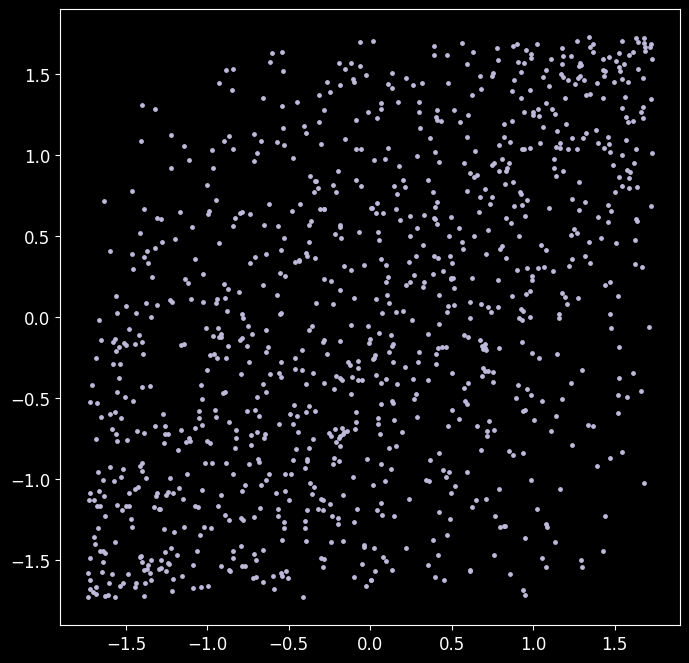

In [ ]:
def get_W(cor):
  cov = [[1 , cor],
         [cor, 1]]
  Z = np.random.multivariate_normal(np.zeros(2), cov)
  return a + (b-a) * scipy.stats.norm.cdf(Z)

N= 1000
W = np.zeros((N,2))
for j in range(N):
    W[j,:] = get_W(0.5)

plt.scatter(W[:,0],W[:,1],s=6,color=cmap(2))

plt.show()


___
___

# Question 3: Generating random samples in some given set (20 pts)

___

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).
___

## Ans.

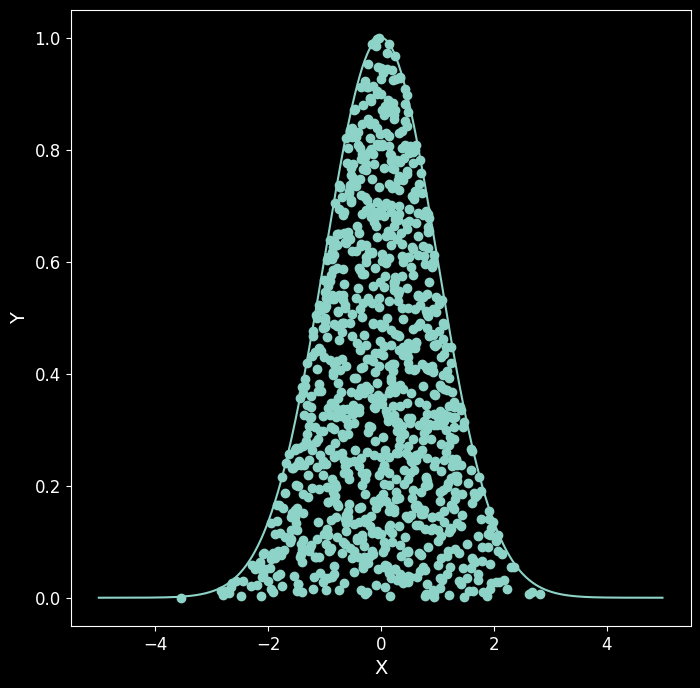

In [37]:
N = 1000
f = lambda x: np.exp(-pow(x,2)/2)
x_axis = np.arange(-5, 5, 0.01)

X = np.random.normal(size=N)
Y = np.random.uniform(0,f(X))

plt.scatter(X,Y)
plt.plot(x_axis,f(x_axis))

plt.xlabel("X")
plt.ylabel("Y")
plt.show()



___
**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).
___

## Ans.

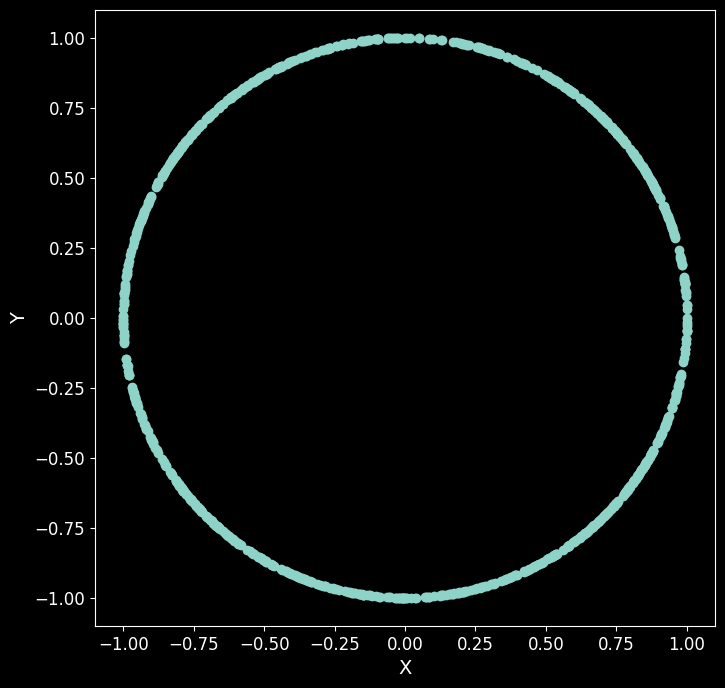

In [34]:
U = np.random.uniform(-1,1,size=N)
V = np.random.uniform(-1,1,size=N)
X = U / np.sqrt(U**2 + V**2)
Y = V / np.sqrt(U**2 + V**2)
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(X,Y)
plt.show()

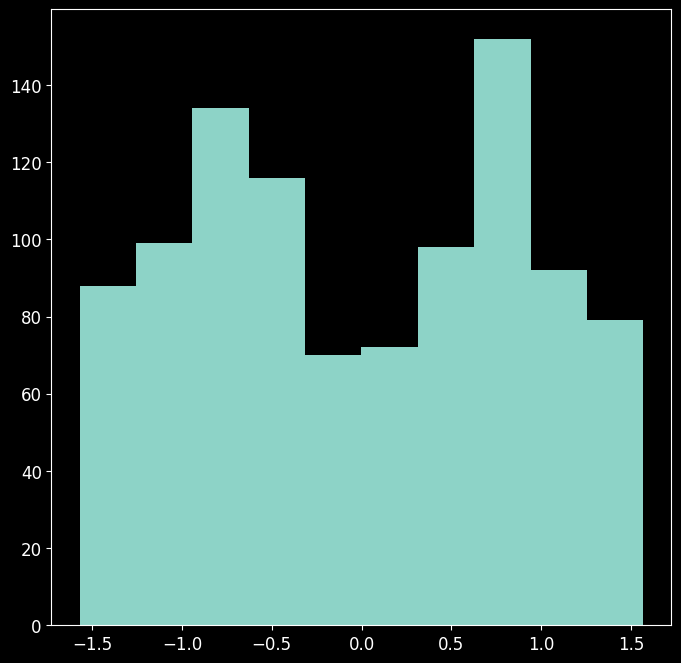

In [35]:
theta = np.arctan(Y/X)
plt.hist(theta)
plt.show()

From the histogram it is clear that these generated points are not uniformly distributed on the circumference of the circle



---

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$, and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

___

## Ans.

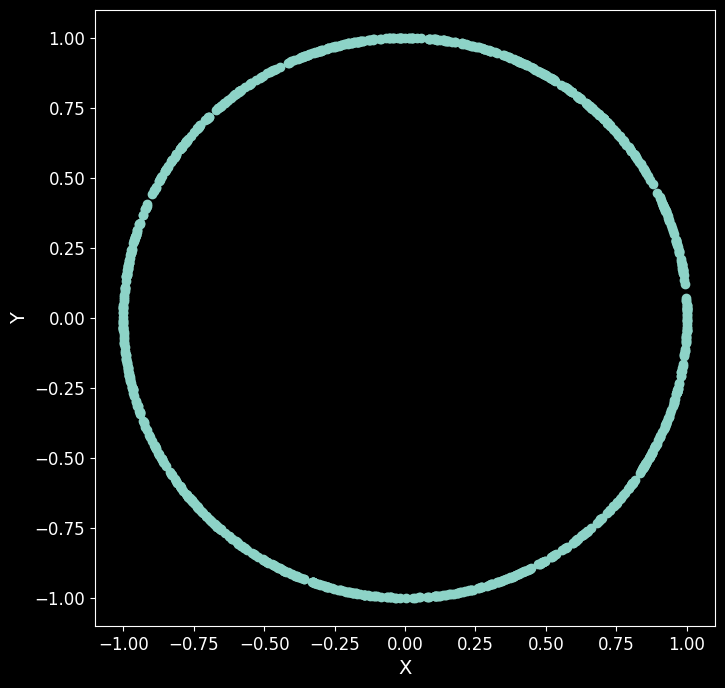

In [41]:
Z = np.random.normal(size=N)
W = np.random.normal(size=N)
X = Z / np.sqrt(Z**2 + W**2)
Y = W / np.sqrt(Z**2 + W**2)
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(X, Y)
plt.show()

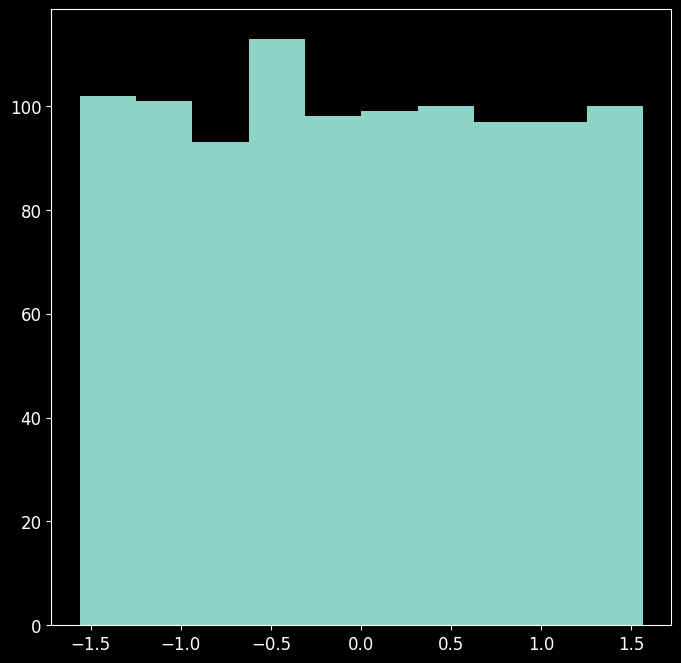

In [39]:
theta = np.arctan(W/Z)
plt.hist(theta)
plt.show()


The data generated in this way seems to be much more uniformly distrbuted. The reason being this is because in (b) we are definitely more likely togenerate points on the line that has an 45-degree/135 degree/225-degree/315-degree angle with x axis, since te distance between the boundary and the centroid is the longests for these lines. Hence if we project the points, we have a higher change of getting points at that angle. In (c) the distribution is more uniform since the points generated in this way has a similar CDF as the actual CDF of the distribution we want to simulate

___
___

# Question 4: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1,000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

___

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.
___


## Ans.

In [46]:
N = 10000
mu = 10
passengers = np.array(sorted(np.random.uniform(0,1000,N)))
time = np.zeros(N)

p = 0
t = 0
while t <= 1000:
    if(p < N and passengers[p] <= t):
        time[p] = t - passengers[p]
        p += 1
    else:
      t += 10


mean = np.mean(time)
l = mean - 1.96*np.std(time)/np.sqrt(N)
r = mean + 1.96*np.std(time)/np.sqrt(N)

print("expected time:", np.mean(time))
print("95% CI = [{}, {}]".format(l,r))

expected time: 4.987489576044755
CI = [4.930357359149559, 5.044621792939951]


___
**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.
___


## Ans.

In [68]:

arrival_time = [0]
while(arrival_time[-1] < 1000):
    arrival_time.append(arrival_time[-1] + np.random.exponential(mu))
L = len(arrival_time)
wait_time = np.zeros(N)
p = 0
prev_time = 0
i = 0
while i < L:
    if(p < N and passengers[p] <= arrival_time[i]):
        wait_time[p] = arrival_time[i] - passengers[p]
        p += 1
    else:
      i += 1


mean = np.mean(wait_time)
l = mean - 1.96*np.std(wait_time)/np.sqrt(N)
r = mean + 1.96*np.std(wait_time)/np.sqrt(N)

print("expected time:", np.mean(wait_time))
print("95% CI = [{}, {}]".format(l,r))

expected time: 8.566045945301466
95% CI = [8.422567016218839, 8.709524874384094]


___

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

___

it is the case in (b)

In [69]:
inter_arrival_time = np.diff(arrival_time)
mean = np.mean(inter_arrival_time)
l = mean - 1.96*np.std(inter_arrival_time)/np.sqrt(L)
r = mean + 1.96*np.std(inter_arrival_time)/np.sqrt(L)

print("expected inter-arrival time:", np.mean(inter_arrival_time))
print("95% CI = [{}, {}]".format(l,r))

expected inter-arrival time: 9.562016591797859
95% CI = [7.932822403206814, 11.191210780388904]


___

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

___

## Ans.

In [73]:
#setting b
sample_inter_time = np.zeros(N)
p = 0
i = 1
while i < L:
    if(p < N and passengers[p] <= arrival_time[i]):
        sample_inter_time[p] = arrival_time[i] - arrival_time[i-1]
        p += 1
    else:
      i += 1

mean = np.mean(sample_inter_time)
l = mean - 1.96*np.std(sample_inter_time)/np.sqrt(N)
r = mean + 1.96*np.std(sample_inter_time)/np.sqrt(N)
print("The sample mean of the interval for setting b is:", mean)
print("95% CI = [{}, {}]".format(l,r))

The sample mean of the interval for setting b is: 17.05863834784318
95% CI = [16.872875831841068, 17.24440086384529]


The sample mean for inter arrival time for setting a would be 10, since the train arrivesdeterministically so nomatter what passenger we choose, the inter arrival time would be 10, and confidence interval is [10, 10], these are the strictly upper bound for the wait time estimate we get for part a, which gives us average wait time around half of interval time. This could be explained as passenger arrival time are also uniformly distributed, it has an equal chance of falling into any of the 10-min interval, and within each interval the wait time is symmetric and thus the mean should be half of interval time

In part (b), the train arrival times follow an exponential distribution, the mean of inter arrival time is approximately twice as large as the wait time of a passenger. Exponential distribution is memoryless. The additional time spent waiting is independent of the time already spent in the past. What that implies here is on average the amount of time a passenger waits should be equal to the mean of exponential distribution, which is 10. This is different from part a as the larger the difference between the two train arrival times, the more likely there are more passengers falling into this interval, making the mean inter-interval larger.

**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  